# Análise de Crédito
Data: 09/06/2020

Objetivo: Analisar, com base no histórico de crédito de clientes de um banco, a probabilidade de inadimplência de um cliente.
Modelo: Random Forest

In [191]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import yaml

### Carregando os dados / Loading the data

In [206]:
with open('./db_config.yaml', 'r') as file:
    db_config = yaml.load(file, Loader=yaml.FullLoader)


In [137]:
dbname = db_config['dbname']
user = db_config['user']
password =  db_config['password']
host =  db_config['host']
port = db_config['port']

###  Conexão com o banco de dados / Connection to the database

In [246]:
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{dbname}")

In [247]:
query_tables = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""

In [248]:
tables = pd.read_sql(query_tables, engine)
print(tables)
dfs = {}
for table in tables["table_name"]:
    dfs[table] = pd.read_sql(f"SELECT * FROM \"{table}\"", engine)


           table_name
0            CLIENTES
1             CREDITO
2             EMPREGO
3         ESTADOCIVIL
4              FIADOR
5           HABITACAO
6   HISTORICO_CREDITO
7       INVESTIMENTOS
8        OUTROSFINANC
9           PROFISSAO
10          PROPOSITO


In [249]:
credito = dfs['CREDITO']

In [266]:
credito.head()

,IDCREDITO,Duracao,HistoricoCredito,Proposito,Valor,Investimentos,Emprego,TempoParcelamento,EstadoCivil,FiadorTerceiros,ResidenciaDesde,Idade,OutrosFinanciamentos,Habitacao,EmprestimoExistente,Profissao,Dependentes,SocioEmpresa,Estrangeiro,Status
0,2,48,2,1,5951,2,3.0,2,1,3,2.0,22,3,1.0,1,4,1,0,0,0
1,3,12,1,2,2096,2,4.0,2,4,3,3.0,49,3,1.0,1,3,2,0,0,1
2,4,42,2,3,7882,2,4.0,2,4,4,4.0,45,3,2.0,1,4,2,0,0,1
3,5,24,3,4,4870,2,3.0,3,4,3,4.0,53,3,2.0,2,4,2,0,0,0
4,6,36,2,2,9055,1,3.0,2,4,3,4.0,35,3,2.0,1,3,2,1,0,1


### Exploração dos dados / Data exploration

In [250]:
credito['Status'].value_counts()

Status
1    700
0    300
Name: count, dtype: int64

In [251]:
credito.isna().sum()

IDCREDITO                0
Duracao                  0
HistoricoCredito         0
Proposito                0
Valor                    0
Investimentos            0
Emprego                 10
TempoParcelamento        0
EstadoCivil              0
FiadorTerceiros          0
ResidenciaDesde          7
Idade                    0
OutrosFinanciamentos     0
Habitacao                9
EmprestimoExistente      0
Profissao                0
Dependentes              0
SocioEmpresa             0
Estrangeiro              0
Status                   0
dtype: int64

In [252]:
credito.dropna(inplace=True)

In [253]:
credito.isna().sum()

IDCREDITO               0
Duracao                 0
HistoricoCredito        0
Proposito               0
Valor                   0
Investimentos           0
Emprego                 0
TempoParcelamento       0
EstadoCivil             0
FiadorTerceiros         0
ResidenciaDesde         0
Idade                   0
OutrosFinanciamentos    0
Habitacao               0
EmprestimoExistente     0
Profissao               0
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
dtype: int64

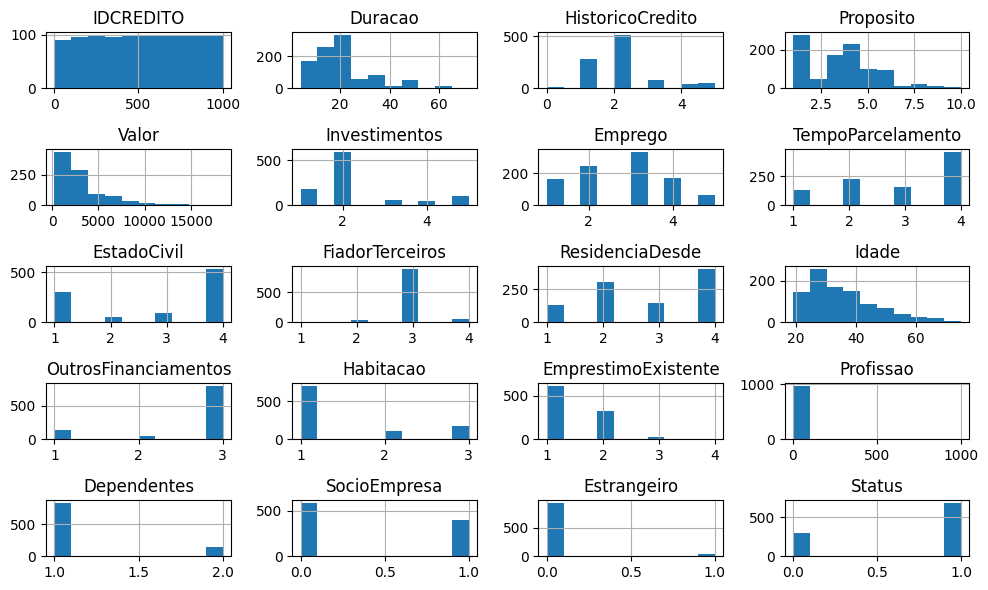

In [254]:
credito.hist(bins=10, figsize=(10, 6))
plt.tight_layout() 
plt.show()

In [255]:
credito = credito[credito['Profissao']<=4]

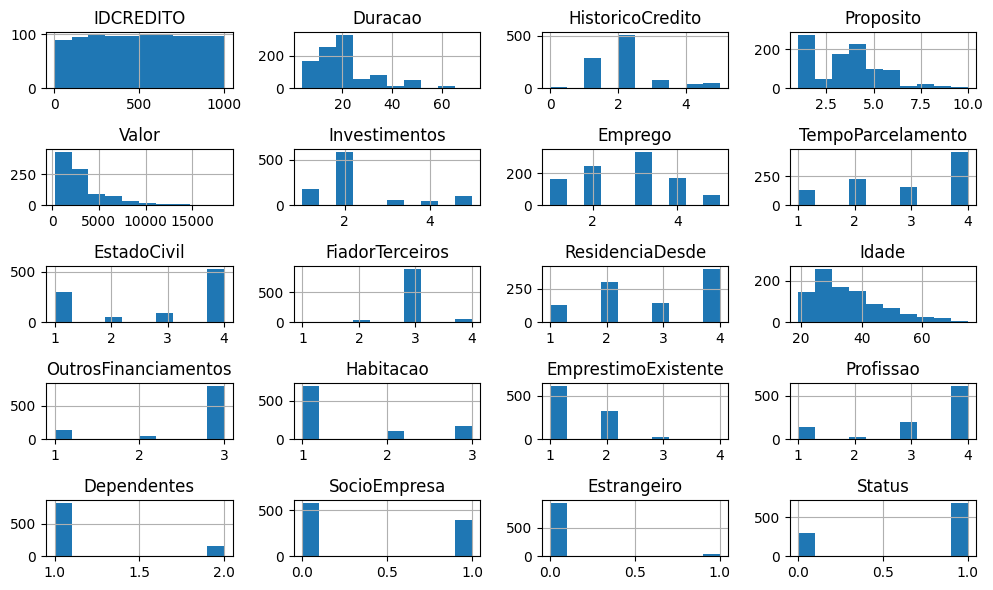

In [267]:
credito.hist(bins=10, figsize=(10, 6))
plt.tight_layout() 
plt.show()

## Modelo / Model

### Separando os dados / Splitting the data

In [256]:
X = credito.drop('Status',axis=1)
y = credito['Status']

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Hyperparameter Tuning 

In [258]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}


In [259]:
model = RandomForestClassifier()

In [260]:
rand_search = RandomizedSearchCV(model,
                                param_distributions = param_dist,
                                cv=5)



### Treinamento / Training

In [261]:
rand_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001634CB2F850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001634C9DECD0>})

In [263]:
model = rand_search.best_estimator_
model

RandomForestClassifier(max_depth=12, n_estimators=355)

### Avaliação do modelo / Model evaluation

In [264]:
y_pred = model.predict(X_test)

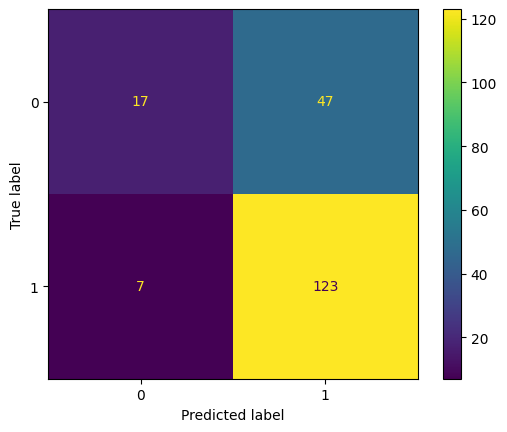

In [265]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [245]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.73
Precision: 0.75
Recall: 0.92


### Importância das variáveis / Feature importances

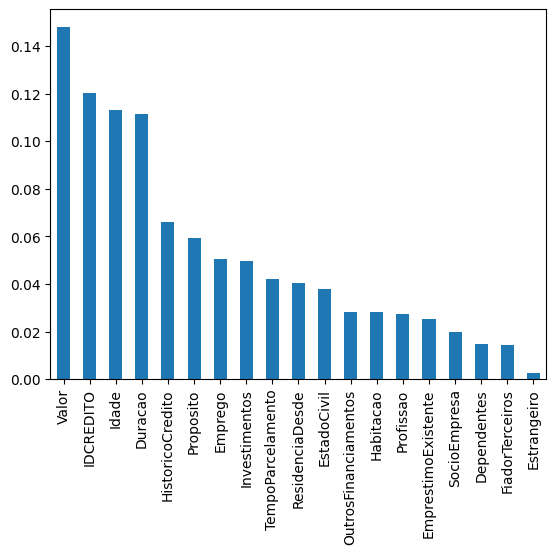

In [240]:
feature_importance = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_importance.plot.bar();

### Visualização do modelo / Model visualization

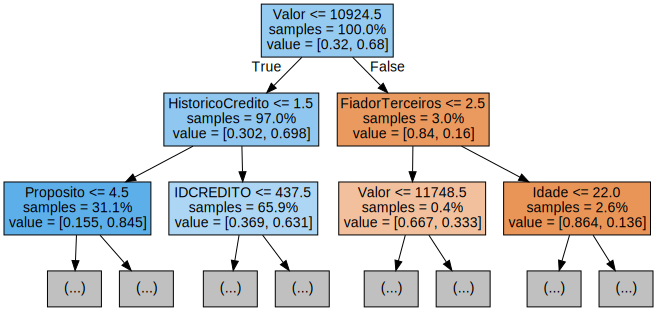

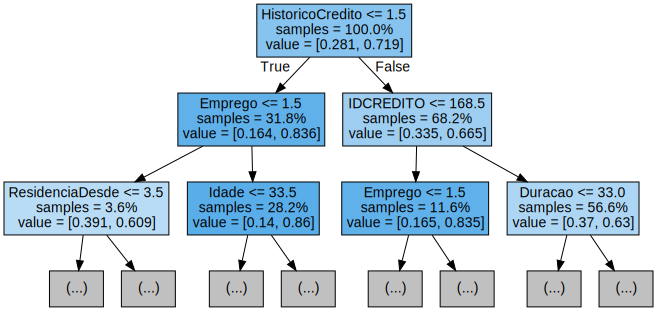

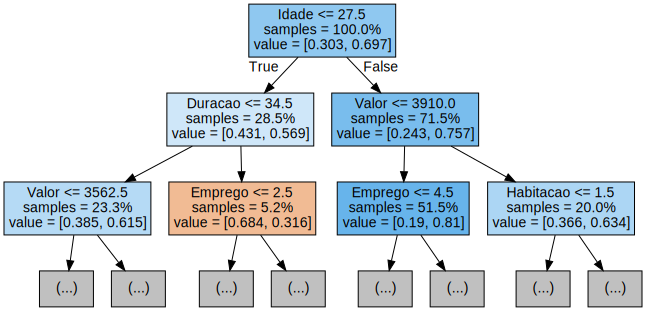

In [180]:
for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)